# Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


In [3]:
titanic=pd.read_csv('/Users/macbookpro/Documents/GitHub/Machine-Learning/data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic=titanic[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']]
titanic['Age']=titanic['Age'].fillna(titanic['Age'].median())
titanic['Fare']=titanic['Fare'].fillna(titanic['Fare'].median())
titanic.head()

,Pclass,Sex,Age,Fare,Survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


In [5]:
label_encoder=LabelEncoder()
titanic['Sex']=label_encoder.fit_transform(titanic['Sex'])
titanic.head()

,Pclass,Sex,Age,Fare,Survived
0,3,1,22.0,7.2500,0
1,1,0,38.0,71.2833,1
2,3,0,26.0,7.9250,1
3,1,0,35.0,53.1000,1
4,3,1,35.0,8.0500,0


In [6]:
X=titanic.drop(columns=['Survived']).values
Y=titanic['Survived'].values

In [7]:
scaler=StandardScaler()
X=scaler.fit_transform(X)
X

array([[ 0.82737724,  0.73769513, -0.56573646, -0.50244517],
       [-1.56610693, -1.35557354,  0.66386103,  0.78684529],
       [ 0.82737724, -1.35557354, -0.25833709, -0.48885426],
       ...,
       [ 0.82737724, -1.35557354, -0.1046374 , -0.17626324],
       [-1.56610693,  0.73769513, -0.25833709, -0.04438104],
       [ 0.82737724,  0.73769513,  0.20276197, -0.49237783]])

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

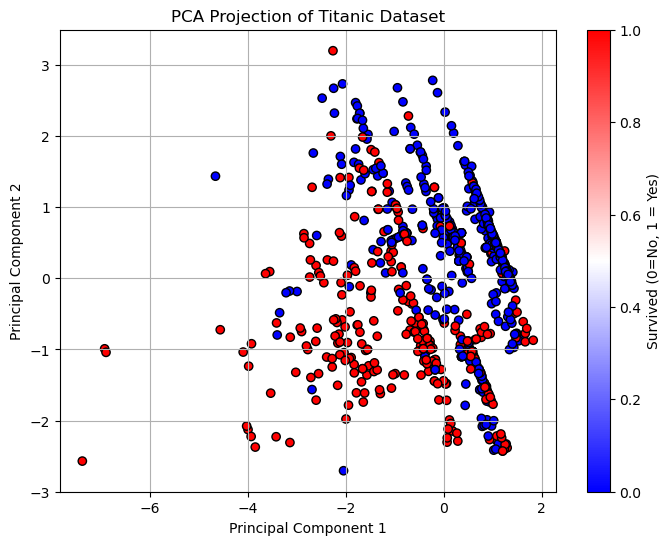

In [9]:
from sklearn.decomposition import PCA

def plot_pca(X, Y):
    """Hiển thị dữ liệu Titanic sau khi giảm chiều bằng PCA để kiểm tra tính tuyến tính"""
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap=plt.cm.bwr, edgecolors='k')
    
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Projection of Titanic Dataset")
    plt.colorbar(label="Survived (0=No, 1 = Yes)")
    plt.grid(True)
    plt.show()

# Gọi hàm hiển thị dữ liệu Titanic
plot_pca(X, Y)


# Model

## Soft margin SVM
<img src="/Users/macbookpro/Documents/GitHub/Machine-Learning/code/lossfuncSVM.png" alt="Loss Function" width="300"/>
<img src="/Users/macbookpro/Documents/GitHub/Machine-Learning/code/capNhatHeSo.png" alt="Update he so" width="300"/>

In [12]:
class SVM:
    def __init__(self, learning_rate=0.001, C=1, n_iters=5000, tolerance=1e-5):
        self.lr = learning_rate
        self.C = C
        self.n_iters = n_iters
        self.tolerance = tolerance
        self.w = None
        self.b = None
        self.losses = []

    def hinge_loss(self, X, y):
        margins = 1 - y * (np.dot(X, self.w) + self.b)
        losses = np.maximum(0, margins)
        #hinge_loss=0.5 * np.dot(self.w, self.w) + self.C * np.sum(losses)
        #print(hinge_loss)
        #return hinge_loss
        #return 0.5 * np.dot(self.w, self.w) + self.C * np.sum(losses)
        return 0.5 * np.linalg.norm(self.w) ** 2 + self.C * np.sum(losses)

    def fit(self, X, y):
        y = np.where(y == 0, -1, 1) 
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0
        prev_loss = float('inf')

        for epoch in range(self.n_iters):
            for index, x_i in enumerate(X):
                condition = y[index] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * self.w 
                else:
                    self.w -= self.lr * (self.w - self.C * y[index] * x_i)
                    #self.w = (1 - self.lr) * self.w + self.lr * self.C * y[index] * x_i
                    self.b += self.lr * self.C * y[index]


            # Tính toán loss
            current_loss = self.hinge_loss(X, y)
            self.losses.append(current_loss)

            if abs(prev_loss - current_loss) < self.tolerance:
                break
            prev_loss = current_loss

    def predict(self, X):
        #print(np.dot(X, self.w) + self.b)
        return np.sign(np.dot(X, self.w) + self.b)

    def plot_loss(self):
        plt.plot(self.losses, label="Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Loss over iterations")
        plt.legend()
        plt.show()

## Kernel SVM

# Huấn luyện mô hình

In [15]:
# Huấn luyện mô hình
svm_model = SVM(learning_rate=0.001, C=1, n_iters=5000)
svm_model.fit(X_train, Y_train)


In [16]:
# Dự đoán
Y_pred = svm_model.predict(X_test)
Y_pred = np.where(Y_pred == -1, 0, 1)


Accuracy: 0.7039106145251397


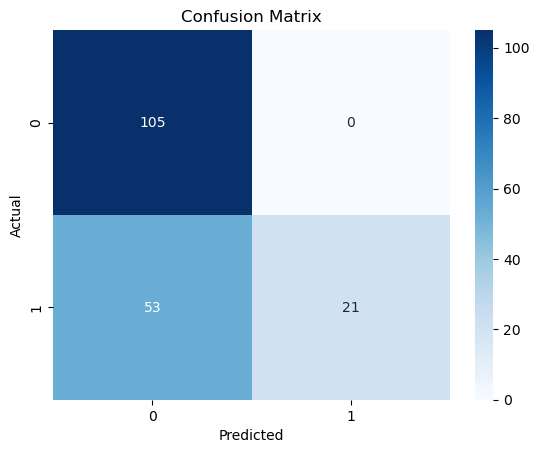

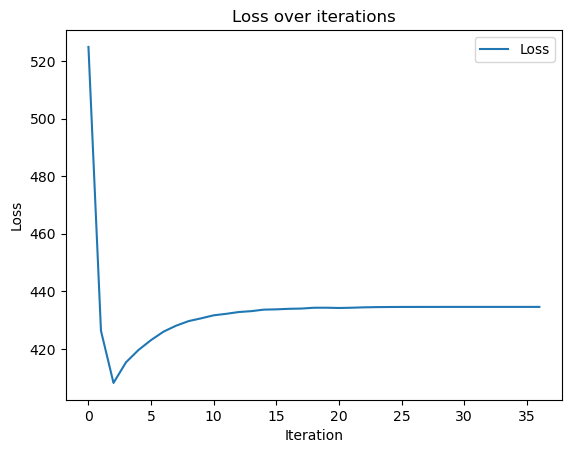

In [17]:
# Đánh giá mô hình
accuracy = np.mean(Y_pred == Y_test)
print("Accuracy:", accuracy)

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Vẽ đồ thị loss
svm_model.plot_loss()

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

linear_svm = SVC(kernel="linear")
linear_svm.fit(X_train, Y_train)
linear_pred = linear_svm.predict(X_test)

rbf_svm = SVC(kernel="rbf")
rbf_svm.fit(X_train, Y_train)
rbf_pred = rbf_svm.predict(X_test)

print("Accuracy of Linear SVM:", accuracy_score(Y_test, linear_pred))
print("Accuracy of RBF SVM:", accuracy_score(Y_test, rbf_pred))


Accuracy of Linear SVM: 0.7821229050279329
Accuracy of RBF SVM: 0.8100558659217877
